In [ ]:
pip install transformers datasets evaluate sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requi

In [ ]:
from transformers import pipeline

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from datasets import load_dataset

books = load_dataset("ascolda/ru_en_Crystallography_and_Spectroscopy")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/106 [00:00<?, ?B/s]

data.json:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44580 [00:00<?, ? examples/s]

In [ ]:
books

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 44580
    })
})

In [ ]:
books = books["train"].train_test_split(test_size=0.2)

In [ ]:
books

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 35664
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 8916
    })
})

In [ ]:
books["train"][0]

{'translation': {'ru': 'Ультратонкая матрица CurvIS, форма и механическая мягкость которой аналогичны сетчатке глаза человека, имеет большой потенциал для использования ее в качестве мягкого фотодетекторного компонента в протезе сетчатки.',
  'en': 'The ultrathin CurvIS array, the shape and mechanical softness of which are the same as those of the retina of a human eye, has great potential for use as a soft photodetector component in retina prosthesis.'}}

In [ ]:
from transformers import AutoTokenizer

checkpoint = "utrobinmv/t5_translate_en_ru_zh_small_1024"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

In [ ]:
max_input_length = 128
max_target_length = 128

source_lang = "en"
target_lang = "ru"


def preprocess_function(examples):
    inputs = [ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_books = books.map(preprocess_function, batched=True)

Map:   0%|          | 0/35664 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/8916 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [ ]:
import evaluate

metric = evaluate.load("sacrebleu")

In [ ]:
import numpy as np


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/221M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="my_awesome_books_model_2",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_books["train"],
    eval_dataset=tokenized_books["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
bleu_before_train = trainer.evaluate()

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
bleu_before_train.get('eval_bleu')

15.8121

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,1.272300,1.016283,38.398200,39.268100
2,1.133200,0.942311,40.341800,39.260500
3,1.065200,0.914992,41.156900,39.286700
4,1.027000,0.904603,41.424700,39.293600


Выходные данные были обрезаны до нескольких последних строк (5000).
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_c

TrainOutput(global_step=8916, training_loss=1.1587780883570005, metrics={'train_runtime': 8310.42, 'train_samples_per_second': 17.166, 'train_steps_per_second': 1.073, 'total_flos': 6031177615540224.0, 'train_loss': 1.1587780883570005, 'epoch': 4.0})

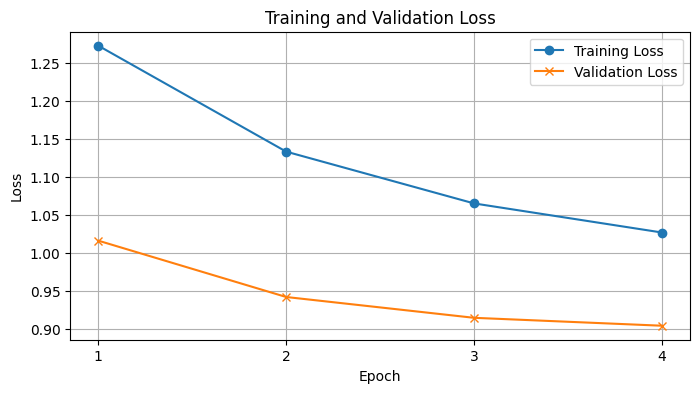

In [ ]:
training_loss = [1.272300, 1.133200, 1.065200, 1.027000]
validation_loss = [1.016283, 0.942311, 0.914992, 0.904603]
epochs = np.arange(1, len(training_loss) + 1)
plt.figure(figsize=(8, 4))

plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='x')


plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.show()

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1735150290.46faf987ff3e.658.0:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Taisiia7/my_awesome_books_model_2/commit/aa482a3551975bafbfb06d4e6022fe95d6e673df', commit_message='End of training', commit_description='', oid='aa482a3551975bafbfb06d4e6022fe95d6e673df', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Taisiia7/my_awesome_books_model_2', endpoint='https://huggingface.co', repo_type='model', repo_id='Taisiia7/my_awesome_books_model_2'), pr_revision=None, pr_num=None)

In [ ]:
text = "Apple is tasty"

In [ ]:
translator = pipeline("translation_en_to_ru", model="Taisiia7/my_awesome_books_model_2")

Device set to use cpu


In [ ]:
translator(text)

[{'translation_text': 'Яблоко вкусное'}]